In [331]:
%load_ext autoreload
%autoreload 2

import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
#import pymaise 



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [332]:
import psutil
import GPUtil

def get_gpu_utilization():
    # Get the list of available GPUs
    gpus = GPUtil.getGPUs()
    
    if len(gpus) == 0:
        print("No GPU found.")
        return
    
    for gpu in gpus:
        print(f"GPU {gpu.id}:")
        print(f"  - GPU name: {gpu.name}")
        print(f"  - GPU load: {gpu.load * 100:.2f}%")
        print(f"  - GPU memory total: {gpu.memoryTotal} MB")
        print(f"  - GPU memory used: {gpu.memoryUsed} MB")
        print(f"  - GPU memory free: {gpu.memoryFree} MB")
        print(f"  - GPU memory utilization: {gpu.memoryUtil * 100:.2f}%")
        print()

def main():
    # Print CPU utilization
    print("CPU utilization:", psutil.cpu_percent(interval=1))
    
    # Print GPU utilization
    get_gpu_utilization()

if __name__ == "__main__":
    main()


CPU utilization: 0.2
GPU 0:
  - GPU name: NVIDIA GeForce RTX 4090
  - GPU load: 0.00%
  - GPU memory total: 24564.0 MB
  - GPU memory used: 22768.0 MB
  - GPU memory free: 1448.0 MB
  - GPU memory utilization: 92.69%

GPU 1:
  - GPU name: NVIDIA GeForce RTX 4090
  - GPU load: 0.00%
  - GPU memory total: 24564.0 MB
  - GPU memory used: 562.0 MB
  - GPU memory free: 23654.0 MB
  - GPU memory utilization: 2.29%



In [333]:
from pyMAISE.datasets import load_anomaly
from pyMAISE.preprocessing import train_test_split, scale_data, one_hot_encode, SplitSequence
import pyMAISE as mai

In [334]:
%%time

global_settings = mai.init(
    problem_type=mai.ProblemType.CLASSIFICATION,   # Define a regression problem
    #cuda_visible_devices="-1"                  # Use CPU only/ Delete line when run on GPU
    verbosity = 3
)

Num GPUs Available:  2
CPU times: user 45 µs, sys: 6 µs, total: 51 µs
Wall time: 56 µs


In [335]:
# call handler
input_path = "/home/jacc/pyMAISE/pyMAISE/datasets/DTL.npy"
output_path = "/home/jacc/pyMAISE/pyMAISE/datasets/DTL_labels.npy"
#print(mai.__file__)
#False, False, False: WORKS       X.shape = (1077, 4500, 14), Y.shape = (1077, 1)  one hot
#False, True, False: WORKS       X.shape = (1077, 4500, 14), Y.shape = (1077, 1)
#False, False, True:  ?      X.shape = (1077, 4500, 14), Y.shape = (1077, 4500, 1)
#False, True, True:   ?      X.shape = (1077, 4500, 14), Y.shape = (1077, 4500, 1)
#True, False, True: WORKS        X.shape = (4846500, 14), Y.shape = (4846500, 1)
#True, True, True: WORKS         X.shape = (4846500, 14), Y.shape = (4846500, 1)
cond1 = True
cond2 = False
cond3 = True
inputs, outputs = load_anomaly([input_path, output_path], cond1, cond2, cond3)


In [336]:
inputs

<xarray.DataArray (timesteps: 4846500, features: 14)>
array([[-6.07100e+00,  5.55120e+00, -1.42220e+00, ..., -4.60370e-02,
         2.17170e+03,  1.27100e+00],
       [-4.85030e+00,  4.33040e+00, -2.64290e+00, ...,  1.50000e-02,
         2.17250e+03, -1.33776e+01],
       [-4.85030e+00,  1.88890e+00, -1.42220e+00, ...,  4.55190e-02,
         2.17320e+03, -8.49500e+00],
       ...,
       [-2.17470e+00, -7.57620e+00, -3.39550e+00, ..., -1.07070e-01,
         2.17220e+03,  1.19730e+01],
       [-4.61620e+00, -3.91400e+00, -5.83700e+00, ..., -1.68110e-01,
         2.17180e+03,  9.53200e+00],
       [-3.39550e+00, -6.35550e+00, -5.83700e+00, ..., -4.60370e-02,
         2.17150e+03,  9.53200e+00]], dtype=float32)
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) <U18 'A+IGBT-I: current' ... 'DV/DT'

In [337]:
outputs

<xarray.DataArray (timesteps: 4846500, features: 1)>
array([['Run'],
       ['Run'],
       ['Run'],
       ...,
       ['Fault'],
       ['Fault'],
       ['Fault']], dtype=object)
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) <U5 'Class'

In [338]:
outputs = one_hot_encode(outputs)
outputs

<xarray.DataArray (timesteps: 4846500, features: 2)>
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) object 'Class_Fault' 'Class_Run'

In [339]:
data = xr.concat([inputs, outputs], dim="features")
data

<xarray.DataArray (timesteps: 4846500, features: 16)>
array([[ -6.0710001 ,   5.55119991,  -1.42219996, ...,   1.27100003,
          0.        ,   1.        ],
       [ -4.85029984,   4.33039999,  -2.64289999, ..., -13.37759972,
          0.        ,   1.        ],
       [ -4.85029984,   1.88890004,  -1.42219996, ...,  -8.49499989,
          0.        ,   1.        ],
       ...,
       [ -2.17470002,  -7.57620001,  -3.39549994, ...,  11.97299957,
          1.        ,   0.        ],
       [ -4.61619997,  -3.91400003,  -5.83699989, ...,   9.53199959,
          1.        ,   0.        ],
       [ -3.39549994,  -6.35550022,  -5.83699989, ...,   9.53199959,
          1.        ,   0.        ]])
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) object 'A+IGBT-I: current' ... 'Class_Run'

In [340]:
split_sequence = SplitSequence(
    10, 
    1, 
    0, 
    sequence_inputs=data.coords["features"].values[:-2], 
    sequence_outputs=data.coords["features"].values[-2:],
)
inputs, outputs = split_sequence.split(data)

inputs

<xarray.DataArray (samples: 4846491, timesteps: 10, features: 14)>
array([[[-6.07100010e+00,  5.55119991e+00, -1.42219996e+00, ...,
         -4.60369997e-02,  2.17169995e+03,  1.27100003e+00],
        [-4.85029984e+00,  4.33039999e+00, -2.64289999e+00, ...,
          1.49999997e-02,  2.17250000e+03, -1.33775997e+01],
        [-4.85029984e+00,  1.88890004e+00, -1.42219996e+00, ...,
          4.55190018e-02,  2.17319995e+03, -8.49499989e+00],
        ...,
        [-3.62960005e+00,  1.88890004e+00, -5.08440018e+00, ...,
         -4.60369997e-02,  2.17239990e+03, -1.17100000e+00],
        [-7.29180002e+00,  1.88890004e+00, -3.86360002e+00, ...,
          1.49999997e-02,  2.17230005e+03, -1.33781004e+01],
        [-7.29180002e+00,  3.10969996e+00, -2.64289999e+00, ...,
         -4.60369997e-02,  2.17280005e+03, -1.17100000e+00]],

       [[-4.85029984e+00,  4.33039999e+00, -2.64289999e+00, ...,
          1.49999997e-02,  2.17250000e+03, -1.33775997e+01],
        [-4.85029984e+00,  1.88890004e+00, -1.42219996e+00, ...,
          4.55190018e-02,  2.17319995e+03, -8.49499989e+00],
        [-7.29180002e+00,  1.88890004e+00, -1.42219996e+00, ...,
          4.55190018e-02,  2.17300000e+03, -2.31439991e+01],
...
        [-4.61619997e+00, -8.79699993e+00, -4.61619997e+00, ...,
          1.49999997e-02,  2.17180005e+03,  4.64900017e+00],
        [-2.17470002e+00, -7.57620001e+00, -3.39549994e+00, ...,
         -1.07069999e-01,  2.17219995e+03,  1.19729996e+01],
        [-4.61619997e+00, -3.91400003e+00, -5.83699989e+00, ...,
         -1.68109998e-01,  2.17180005e+03,  9.53199959e+00]],

       [[-7.05770016e+00, -7.57620001e+00, -3.39549994e+00, ...,
          1.06559999e-01,  2.17180005e+03,  7.09000015e+00],
        [-4.61619997e+00, -6.35550022e+00, -7.05770016e+00, ...,
         -4.60369997e-02,  2.17160010e+03,  7.09100008e+00],
        [-3.39549994e+00, -8.79699993e+00, -2.17470002e+00, ...,
         -4.60369997e-02,  2.17180005e+03,  1.19740000e+01],
        ...,
        [-2.17470002e+00, -7.57620001e+00, -3.39549994e+00, ...,
         -1.07069999e-01,  2.17219995e+03,  1.19729996e+01],
        [-4.61619997e+00, -3.91400003e+00, -5.83699989e+00, ...,
         -1.68109998e-01,  2.17180005e+03,  9.53199959e+00],
        [-3.39549994e+00, -6.35550022e+00, -5.83699989e+00, ...,
         -4.60369997e-02,  2.17150000e+03,  9.53199959e+00]]])
Coordinates:
  * samples    (samples) int64 0 1 2 3 4 ... 4846487 4846488 4846489 4846490
  * timesteps  (timesteps) int64 0 1 2 3 4 5 6 7 8 9
  * features   (features) object 'A+IGBT-I: current' ... 'DV/DT'

In [341]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler






In [342]:
xtrain, xtest, ytrain, ytest = train_test_split(inputs, outputs, test_size=0.3)



In [343]:
xtrain, xtest, x_scaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())



In [344]:
ytrain, ytest, y_scaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

In [345]:
%%time


xtrain = xtrain[:8000]
ytrain = ytrain[:8000]

xtest = xtest[:2000]
ytest = ytest[:2000]


CPU times: user 406 µs, sys: 57 µs, total: 463 µs
Wall time: 469 µs


In [346]:
xtrain.shape

(8000, 10, 14)

In [347]:
ytrain.shape[-1]

2

In [348]:
lstm_structure = {
    "LSTM_input": {
        "units": 50,
        "return_sequences": True,
        "input_shape": (xtrain.shape[1], xtrain.shape[2]),
    },
    "LSTM": {
        "num_layers": mai.Int(min_value=0, max_value=3),
        "units": 50,
        "return_sequences": True,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",
    },
#check activation to lstm to classification
    "LSTM_output": {
        "units": 50,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",

        
    },
    "Dense":{
         "num_layers": mai.Int(min_value=0, max_value=3),
         "units": mai.Int(min_value=25, max_value=250),
         "activation": "sigmoid", #do research on relu activation CHANGED
         "kernel_initializer": "normal",
         "sublayer": mai.Choice(["Dropout_hidden", "None"]),
         "Dropout_hidden": {
         "rate": mai.Float(min_value=0.4, max_value=0.6),}
    },
    "Dense_output": {
        "units": ytrain.shape[1],
        "activation": "softmax",
    },
}
#change nodes in each layer, not in the output
fitting = {
    "batch_size":128,# mai.Choice([16, 32, 64]),
    "epochs": 5,
    "validation_split":0.15,
    "callbacks": [
        ReduceLROnPlateau(
            monitor='accuracy',
            factor=0.8,
            patience=2,
            min_lr=0,
            verbose=1,
        ),
        EarlyStopping(
            monitor="accuracy",
            patience=3,
        )
    ]
}
adam = {
    "learning_rate": mai.Float(min_value=0.00001, max_value=0.001),
   # "clipnorm": mai.Float(min_value=0.8, max_value=1.2),
  #  "clipvalue": mai.Float(min_value=0.3, max_value=0.7),
}
compiling = {
    "loss": "binary_crossentropy",#figure out accuracy on keras keras lstm on classification
    "metrics": ["accuracy"],
}

model_settings = {
    "models": ["LSTM"],
    "LSTM": {
        "structural_params": lstm_structure,
        "optimizer": "Adam",
        "Adam": adam,
        "compile_params": compiling,
        "fitting_params": fitting,
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

In [349]:
xtrain.shape

(8000, 10, 14)

In [350]:
lstm_structure

{'LSTM_input': {'units': 50,
  'return_sequences': True,
  'input_shape': (10, 14)},
 'LSTM': {'num_layers': <pyMAISE.utils.hyperparameters.Int at 0x716ccad4cb10>,
  'units': 50,
  'return_sequences': True,
  'activation': 'tanh',
  'recurrent_activation': 'sigmoid'},
 'LSTM_output': {'units': 50,
  'activation': 'tanh',
  'recurrent_activation': 'sigmoid'},
 'Dense': {'num_layers': <pyMAISE.utils.hyperparameters.Int at 0x716ccada7dd0>,
  'units': <pyMAISE.utils.hyperparameters.Int at 0x716bdaa77a50>,
  'activation': 'sigmoid',
  'kernel_initializer': 'normal',
  'sublayer': <pyMAISE.utils.hyperparameters.Choice at 0x716bdaa75450>,
  'Dropout_hidden': {'rate': <pyMAISE.utils.hyperparameters.Float at 0x716bdaa74a10>}},
 'Dense_output': {'units': 2, 'activation': 'softmax'}}

In [351]:
ytrain.shape

(8000, 2)

In [352]:

start = time.time()

bayesian_search_configs = tuner.nn_bayesian_search(
    objective="accuracy_score",
    max_trials=5,
    cv=5,
)

print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Trial 5 Complete [00h 00m 44s]
accuracy_score: 0.8467499999999999

Best accuracy_score So Far: 0.8745
Total elapsed time: 00h 02m 37s

Top Configurations

-- LSTM | Training Time: 00:02:37
LSTM_num_layers: 0
Dense_num_layers: 0
Adam_learning_rate: 0.0005516381655236106
Dense_0_units: 141
Dense_0_sublayer: Dropout_hidden
Dense_0_sublayer_Dropout_hidden_0_rate: 0.48166682748937173
Dense_1_units: 204
Dense_1_sublayer: Dropout_hidden
Dense_1_sublayer_Dropout_hidden_0_rate: 0.5615758367414165
Hyperparameter tuning took 2.6186137477556866 minutes to process.


In [353]:
xtrain

<xarray.DataArray (samples: 8000, timesteps: 10, features: 14)>
array([[[0.59654491, 0.60187091, 0.80094247, ..., 0.48692795,
         0.9090861 , 0.41931329],
        [0.59776737, 0.60250769, 0.80135344, ..., 0.48509339,
         0.90958338, 0.42174107],
        [0.59776737, 0.60346323, 0.80217532, ..., 0.48601135,
         0.90994507, 0.42654709],
        ...,
        [0.60204584, 0.60473704, 0.80546296, ..., 0.48601135,
         0.90980942, 0.43506912],
        [0.60235145, 0.60728452, 0.80546296, ..., 0.48692795,
         0.90994507, 0.43145222],
        [0.60296267, 0.60696608, 0.80546296, ..., 0.48692795,
         0.9102615 , 0.44230293]],

       [[0.5904326 , 0.08217245, 0.28930962, ..., 0.49518098,
         0.93905917, 0.28504186],
        [0.59073828, 0.06592058, 0.30203468, ..., 0.49242997,
         0.93919482, 0.28504186],
        [0.59104371, 0.05412949, 0.3160053 , ..., 0.49242997,
         0.93829066, 0.28261408],
...
        [0.52294963, 0.60545233, 0.79534662, ..., 0.48967896,
         0.93132862, 0.62904425],
        [0.47894302, 0.60449704, 0.79411384, ..., 0.48326049,
         0.93141901, 0.62057177],
        [0.44318546, 0.6095921 , 0.79822355, ..., 0.47684081,
         0.93105733, 0.60124858]],

       [[0.57301221, 0.44328271, 0.79231247, ..., 0.49884904,
         0.9436704 , 0.38666204],
        [0.56690116, 0.44328271, 0.79272351, ..., 0.49793199,
         0.94376091, 0.39270674],
        [0.5662903 , 0.45028954, 0.79190143, ..., 0.49518098,
         0.9436704 , 0.38666204],
        ...,
        [0.58921014, 0.52639953, 0.79395629, ..., 0.48509339,
         0.9436704 , 0.34915524],
        [0.58737632, 0.55091823, 0.79190143, ..., 0.48326049,
         0.94380605, 0.34311054],
        [0.53633837, 0.52321437, 0.79066865, ..., 0.48509339,
         0.94317317, 0.33102116]]])
Coordinates:
  * samples    (samples) int64 620170 1625806 1219904 ... 3031675 1001908 540556
  * timesteps  (timesteps) int64 0 1 2 3 4 5 6 7 8 9
  * features   (features) object 'A+IGBT-I: current' ... 'DV/DT'

In [354]:
ytrain.shape

(8000, 2)

In [355]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 10}},
    },
  #  y_scaler=y_scaler,
)

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
63/63 [==============================] - 0s 1ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
63/63 [==============================] - 1s 2ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5

Epoch 3: ReduceLROnPlateau reducing learning rate to 6.208515260368586e-05.
Epoch 4/5
63/63 [==============================] - 0s 1ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005313268397003412.
Epoch 5/5
63/63 [==============================] - 1s 4ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020534880459308625.
63/63 [==============================] - 1s 3ms/step


In [356]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train Accuracy,Train Recall,Train Precision,Train F1,Test Accuracy,Test Recall,Test Precision,Test F1
0,LSTM,"{'LSTM_num_layers': 0, 'Dense_num_layers': 0, ...",0.87750,0.87750,0.87750,0.87750,0.8925,0.8925,0.8925,0.8925
1,LSTM,"{'LSTM_num_layers': 1, 'Dense_num_layers': 2, ...",0.84675,0.84675,0.84675,0.84675,0.8610,0.8610,0.8610,0.8610
2,LSTM,"{'LSTM_num_layers': 0, 'Dense_num_layers': 0, ...",0.84675,0.84675,0.84675,0.84675,0.8610,0.8610,0.8610,0.8610
3,LSTM,"{'LSTM_num_layers': 3, 'Dense_num_layers': 2, ...",0.84675,0.84675,0.84675,0.84675,0.8610,0.8610,0.8610,0.8610
4,LSTM,"{'LSTM_num_layers': 3, 'Dense_num_layers': 3, ...",0.84675,0.84675,0.84675,0.84675,0.8610,0.8610,0.8610,0.8610


In [357]:
for model in [ "LSTM"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: LSTM
LSTM_num_layers: 0
Dense_num_layers: 0
Adam_learning_rate: 0.0005516381655236106
Dense_0_units: 141
Dense_0_sublayer: Dropout_hidden
Dense_0_sublayer_Dropout_hidden_0_rate: 0.48166682748937173
Dense_1_units: 204
Dense_1_sublayer: Dropout_hidden
Dense_1_sublayer_Dropout_hidden_0_rate: 0.5615758367414165



In [358]:
idx = postprocessor._get_idx()
idx

0

In [359]:
#postprocessor._models()
yhat_test = postprocessor._models["Test Yhat"][idx]

In [360]:
postprocessor.get_model()

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


In [361]:
 yhat_test

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [362]:
#postprocessor.confusion_matrix(model_type = "LSTM")
yhat_train = postprocessor._models["Train Yhat"][idx]
yhat_test = postprocessor._models["Test Yhat"][idx]


In [363]:
ytrain = postprocessor._ytrain.values
ytest = postprocessor._ytest.values

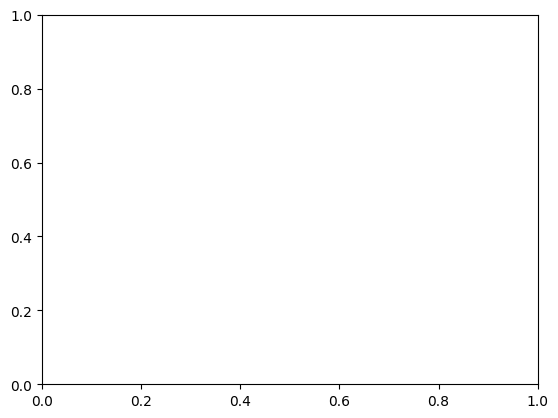

In [364]:
ax = plt.gca()

In [365]:
from sklearn.preprocessing import StandardScaler

ytrain = y_scaler.inverse_transform(
                ytrain.reshape(-1, ytrain.shape[-1])
            )
ytest = y_scaler.inverse_transform(ytest.reshape(-1, ytest.shape[-1]))

In [366]:
#ytrain = one_hot_encode(ytrain)

In [367]:
ytrain = np.round(ytrain).astype(int)
ytrain.shape

(8000, 2)

In [368]:
yhat_train.shape

(8000, 2)

In [369]:
yhat_train = np.argmax(yhat_train, axis=1)

In [370]:
ytrain = np.argmax(ytrain, axis=1)

In [371]:
yhat_train.shape

(8000,)

In [372]:
ytrain.shape

(8000,)

In [373]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
)
from sklearn.metrics import confusion_matrix

train_cm = confusion_matrix(ytrain_single , yhat_train_single)
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm)
#test_cm = postprocessor.confusion_matrix(ytest, yhat_test)
#test_disp = postprocessor.ConfusionMatrixDisplay(confusion_matrix=test_cm)



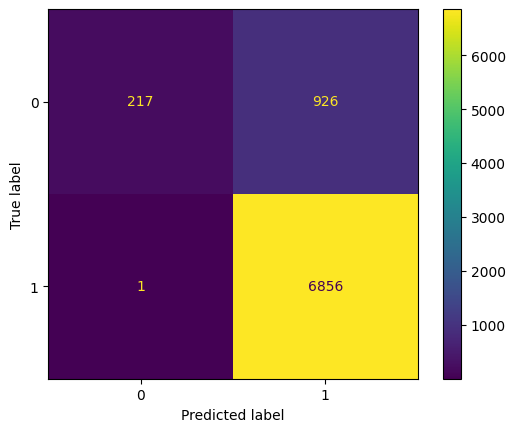

In [376]:
train_disp.plot()

In [ ]:
idx

In [ ]:
postprocessor._models["Train Yhat"]#[idx]


In [ ]:
postprocessor._models["Train Yhat"][idx]